<a href="https://colab.research.google.com/github/JulieaMammen/Homelessness/blob/main/JulieMammen_DATA_3320_Homelessness_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

The purpose of this notebook is to analyze the cleaned data in order to predict homelessness rates in relation to housing market factors. 

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler

# Train-test splits
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from scipy.stats import uniform, randint
import xgboost as xgb

# Model preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import uniform, randint
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Load the Data

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/JulieaMammen/Homelessness/main/full_homeless_data.csv')

## State your questions

The overall problem is to determine whether and how housing market factors are related to homelessness. To answer this problem, we need to ask more specific question to guide our analysis.

*   What columns are predictors in the model?
*   How well does a multiple linear regression model fit the full data set?
*   What predictors are important?
*   Do we need to transform anything nonlinearly?
*   Does a logarithmic fit help with the skew in the data?

## Analysis


Now that we have our questions, we can start our analysis. First, let's revisit our cleaned data.

In [4]:
df.columns

Index(['year', 'coc_number', 'total_homeless', 'total_sheltered',
       'total_unsheltered', 'total_population', 'house_price_index_2009',
       'log_median_rent', 'utility_costs',
       'percentage_owners_cost_burden_2016',
       'percentage_renters_severe_cost_burden_2016', 'share_renters_2016',
       'rental_vacancy_rate', 'high_housing_density', 'number_eviction',
       'share_overcrowded_units_2016', 'city_or_urban', 'suburban',
       'rate_unemployment', 'gini_coefficient_2016', 'poverty_rate',
       'share_HUD_units', 'HUD_unit_occupancy_rate', 'share_built_before_1940',
       'total_black', 'total_latino_hispanic', 'total_asian',
       'total_pacific_islander', 'total_population_0_19',
       'total_population_65_plus', 'total_female_population', 'net_migration',
       'migration_4_year_change', 'proportion_one_person_households',
       'share_under_18_with_single_parent', 'share_veteran_status',
       'share_no_bachelors', 'medicare_reimbursements_per_enrollee',
 

## Full Linear Regression Model

Now let's fit a full linear regression model and a correlation matrix to see if we can find the most relevant predictors.

In [5]:
variable_remove = ["total_sheltered", "total_unsheltered", "total_black", "total_latino_hispanic", "total_asian", "total_pacific_islander", "total_population_0_19", "total_population_65_plus", "total_female_population", "year", "rate_unsheltered", "rate_sheltered"]

In [6]:
df = df.drop(columns = variable_remove)

In [7]:
X = df[df.columns.difference(['coc_number', 'rate_homeless', 'total_population', 'total_homeless'])]
y = df['rate_homeless']

In [8]:
X.head()

,HUD_unit_occupancy_rate,average_Jan_temperature,average_summer_temperature,city_or_urban,gini_coefficient_2016,high_housing_density,house_price_index_2009,log_median_rent,medicare_reimbursements_per_enrollee,migration_4_year_change,...,share_built_before_1940,share_no_bachelors,share_overcrowded_units_2016,share_renters_2016,share_under_18_with_single_parent,share_veteran_status,suburban,total_Jan_precipitation,total_annual_precipitation,utility_costs
0,99.000000,13.800000,60.799999,1,42.010002,0,11.743647,2.438863,8.751520,-0.849202,...,0.366995,65.634148,4.117406,39.727921,23.379078,14.535126,0,1.710000,16.500000,8.500000
1,99.000000,13.800000,60.799999,0,40.675701,0,9.042710,2.249699,9.972870,-0.466562,...,2.236410,75.560379,9.294898,33.922234,19.786558,14.142518,0,1.710000,16.500000,14.607715
2,95.083710,50.995346,80.874313,0,47.633533,0,-0.852477,1.862248,9.318163,-0.000659,...,7.191579,65.983711,1.235925,31.769621,32.077599,9.149558,1,6.669876,38.593376,19.492331
3,87.000801,57.893360,81.939949,1,46.713249,0,-8.507004,1.858394,8.709522,0.208839,...,3.681716,74.543457,1.712736,32.109203,33.668129,11.647923,0,12.296666,58.519012,18.899839
4,95.178665,48.382103,79.429985,0,45.165546,0,0.751167,1.362010,8.967195,0.231822,...,5.150007,82.332657,1.539988,27.708206,27.959316,9.135015,0,5.462999,44.778618,18.803186


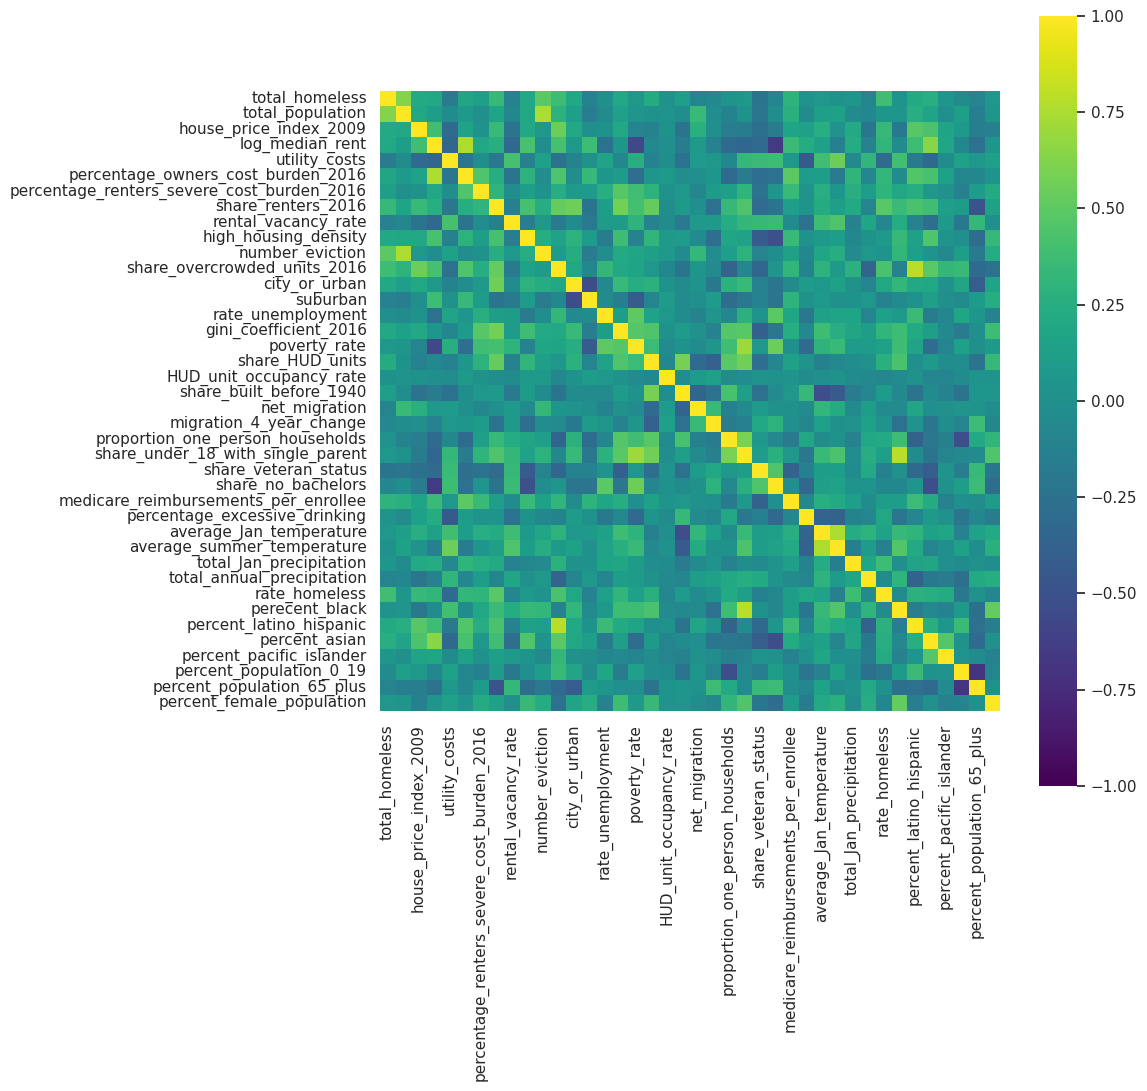

In [9]:
corr_matrix = df.drop(columns = ['coc_number']).corr()

plt.figure(figsize=(10,10))

sns.heatmap(corr_matrix, vmax=1, vmin=-1, square=True, cmap='viridis');

We can ascertain the most relevant predictors from the correlation matrix to see what the most relevant predictors.

In [10]:
np.abs(corr_matrix['rate_homeless']).sort_values(ascending = False).head(10)

rate_homeless                         1.000000
share_renters_2016                    0.477083
share_overcrowded_units_2016          0.423628
total_homeless                        0.386337
total_Jan_precipitation               0.371797
house_price_index_2009                0.337357
percentage_owners_cost_burden_2016    0.316431
gini_coefficient_2016                 0.312237
log_median_rent                       0.311470
utility_costs                         0.306133
Name: rate_homeless, dtype: float64

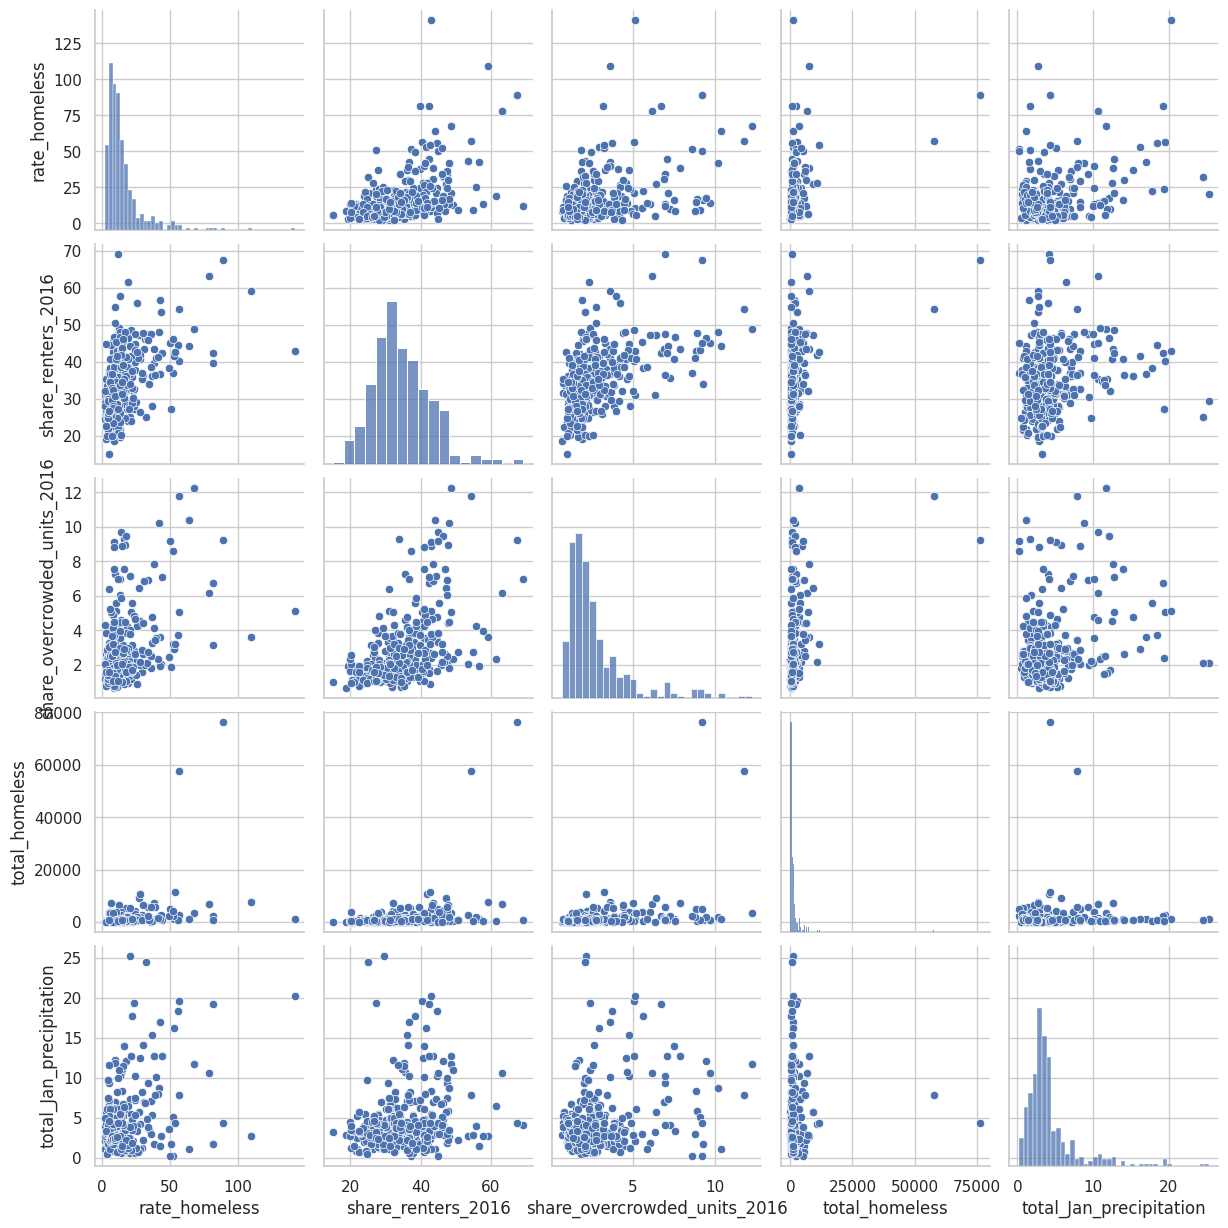

In [11]:
corr_columns = (np.abs(corr_matrix['rate_homeless']).
                sort_values(ascending = False).
                head(5).
                index.
                values)

sns.pairplot(df[corr_columns]);

## Fit Models on the Full Data Set

Now we can fit models on the data set to see if our training data is an accurate measure in helping us predict homelessness rates.

In [12]:
scaler = RobustScaler().fit(X)

In [13]:
X = pd.DataFrame(data=scaler.transform(X), columns=X.columns.values, index=X.index)

In [14]:
X.head()

,HUD_unit_occupancy_rate,average_Jan_temperature,average_summer_temperature,city_or_urban,gini_coefficient_2016,high_housing_density,house_price_index_2009,log_median_rent,medicare_reimbursements_per_enrollee,migration_4_year_change,...,share_built_before_1940,share_no_bachelors,share_overcrowded_units_2016,share_renters_2016,share_under_18_with_single_parent,share_veteran_status,suburban,total_Jan_precipitation,total_annual_precipitation,utility_costs
0,1.231444,-1.463615,-1.717155,1.0,-1.031560,0.0,0.534896,1.128996,-0.593229,-1.382357,...,-0.651757,-0.350919,1.347742,0.557477,-0.169425,1.429165,0.0,-0.751095,-1.970461,-1.537013
1,1.231444,-1.463615,-1.717155,0.0,-1.436983,0.0,0.367384,0.661854,0.174542,-0.771913,...,-0.524037,0.378822,4.712889,0.035500,-0.596108,1.303447,0.0,-0.751095,-1.970461,-0.086112
2,0.427662,0.835357,0.671251,0.0,0.677134,0.0,-0.246315,-0.294961,-0.237023,-0.028632,...,-0.185495,-0.325220,-0.525097,-0.158037,0.863695,-0.295369,1.0,1.472988,0.001087,1.074238
3,-1.231280,1.261710,0.798039,1.0,0.397508,0.0,-0.721048,-0.304478,-0.619630,0.305590,...,-0.425292,0.304061,-0.215191,-0.127506,1.052602,0.504642,0.0,3.996126,1.779192,0.933491
4,0.447151,0.673838,0.499408,0.0,-0.072757,0.0,-0.146857,-1.530302,-0.457651,0.342256,...,-0.324977,0.876695,-0.327469,-0.523191,0.374568,-0.300026,0.0,0.931806,0.553040,0.910531


In [15]:
full_model = sm.OLS(y, sm.add_constant(X)).fit()

In [16]:
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:          rate_homeless   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     12.44
Date:                Wed, 24 May 2023   Prob (F-statistic):           1.18e-43
Time:                        21:24:57   Log-Likelihood:                -1394.3
No. Observations:                 374   AIC:                             2865.
Df Residuals:                     336   BIC:                             3014.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

We can see a decently significant r-squared value of 0.578, which indicates that this training data is a good fit.

In [17]:
X.shape

(374, 37)

However, we can see that we are like overfitting as there are 374 observatios with only 37 variables.

In [18]:
y_pred_lr = full_model.predict(sm.add_constant(X))

In [19]:
MSE = mean_squared_error(y, y_pred_lr)
RMSE = np.sqrt(MSE)
R_squared = r2_score(y, y_pred_lr)

print('MSE = ', MSE.round(3), ' RMSE =', RMSE.round(3), ' R-squared =', R_squared.round(3))

MSE =  101.345  RMSE = 10.067  R-squared = 0.578


In [20]:
mean_absolute_error(y, y_pred_lr)

6.7307669497513345

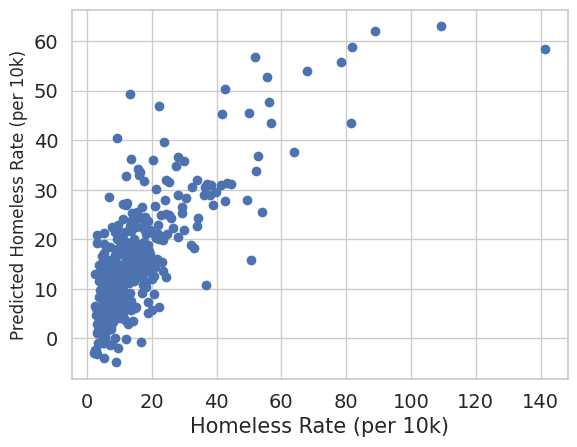

In [21]:
plt.plot(df['rate_homeless'], y_pred_lr, 'o')

plt.xlabel('Homeless Rate (per 10k)', fontsize=15)
plt.ylabel('Predicted Homeless Rate (per 10k)')
plt.tick_params(labelsize=14)

1.   We have too many predictors for the data set size
2.   There are outliers: areas with high homeless rates that might be unique
3. The model might need to be nonlinear in some way



## Train Test Split

Now we'll perform the train test split in order to try and dive deeper into our analysis and find a better fit for the data models.

In [22]:
X = df.drop(columns = ['coc_number', 'rate_homeless'])
y = df['rate_homeless']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 122)

In [24]:
print(X_train.shape, np.round(X_train.shape[0]/X_train.shape[1]))

(299, 39) 8.0


In [25]:
scaler = RobustScaler().fit(X_train)

In [26]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [28]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          rate_homeless   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     12.37
Date:                Wed, 24 May 2023   Prob (F-statistic):           4.25e-40
Time:                        21:25:35   Log-Likelihood:                -1105.4
No. Observations:                 299   AIC:                             2291.
Df Residuals:                     259   BIC:                             2439.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.8466      2.038      8.756      0.0

We can see this model is of significan as it has a large r-squared value of 0.651

In [29]:
variables = X.columns
variables = np.insert(variables, 0, 'intercept')

pd.DataFrame(index = variables, data = {'p-value': model.pvalues.values.round(3), 'significant': model.pvalues.values < 0.05})

,p-value,significant
intercept,0.000,True
total_homeless,0.000,True
total_population,0.000,True
house_price_index_2009,0.124,False
log_median_rent,0.010,True
utility_costs,0.589,False
percentage_owners_cost_burden_2016,0.363,False
percentage_renters_severe_cost_burden_2016,0.227,False
share_renters_2016,0.761,False
rental_vacancy_rate,0.738,False


In [30]:
MSE = mean_squared_error(y_test, model.predict(sm.add_constant(X_test)))
RMSE = np.sqrt(MSE)
R_squared = r2_score(y_test, model.predict(sm.add_constant(X_test)))

print('MSE =', MSE.round(3), ' RMSE =', RMSE.round(3), ' R-squared =', R_squared.round(3))

MSE = 74.863  RMSE = 8.652  R-squared = 0.281


## Lasso Regression

Now we'll perform lasson and ridge regression in order to prevent overfitting of the data. 

In [31]:
alphas = 10**np.linspace(-4,1,10)

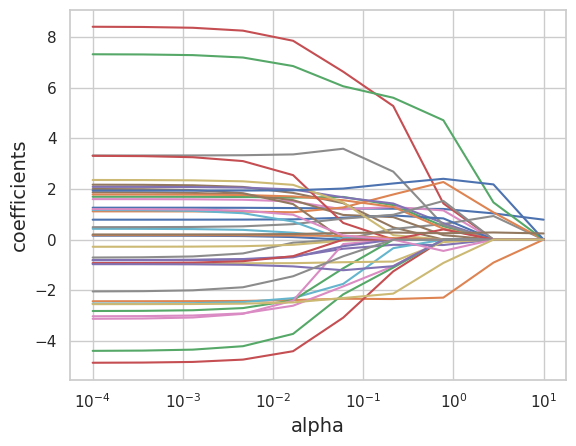

In [32]:
lasso = Lasso(max_iter = 100000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('coefficients', fontsize = 14);

In [33]:
lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100_000)

In [34]:
lassocv.fit(X_train, y_train)
lassocv.alpha_

0.17131690657884072

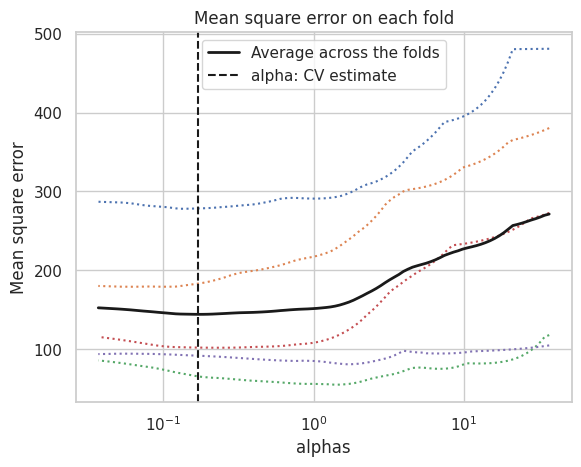

In [35]:
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, ":")
plt.plot(
    lassocv.alphas_ ,
    lassocv.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    lassocv.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight");

In [36]:
lasso_reg = Lasso(alpha = lassocv.alpha_).fit(X_train, y_train)

In [37]:
coefficients = lasso_reg.coef_.round(3)
coefficients = np.insert(coefficients, 0, lasso_reg.intercept_.round(4))

variables = X.columns
variables = np.insert(variables, 0, 'intercept')

pd.DataFrame(data = coefficients.round(2), index = variables, columns = ['Estimated Coefficient'])

,Estimated Coefficient
intercept,14.08
total_homeless,1.22
total_population,-2.33
house_price_index_2009,1.44
log_median_rent,5.62
utility_costs,-0.25
percentage_owners_cost_burden_2016,0.65
percentage_renters_severe_cost_burden_2016,1.26
share_renters_2016,0.37
rental_vacancy_rate,-0.00


In [38]:
MSE_lasso = mean_squared_error(y_test, lasso_reg.predict(X_test))
RMSE_lasso = np.sqrt(MSE_lasso)
R_squared_lasso = r2_score(y_test, lasso_reg.predict(X_test))

print('MSE =', MSE_lasso.round(3), ' RMSE =', RMSE_lasso.round(3), ' R-squared =', R_squared_lasso.round(3))

MSE = 68.581  RMSE = 8.281  R-squared = 0.341


In [39]:
MSE_lasso = mean_squared_error(y_train, lasso_reg.predict(X_train))
RMSE_lasso = np.sqrt(MSE_lasso)
R_squared_lasso = r2_score(y_train, lasso_reg.predict(X_train))

print('MSE =', MSE_lasso.round(3), ' RMSE =', RMSE_lasso.round(3), ' R-squared =', R_squared_lasso.round(3))

MSE = 98.923  RMSE = 9.946  R-squared = 0.637


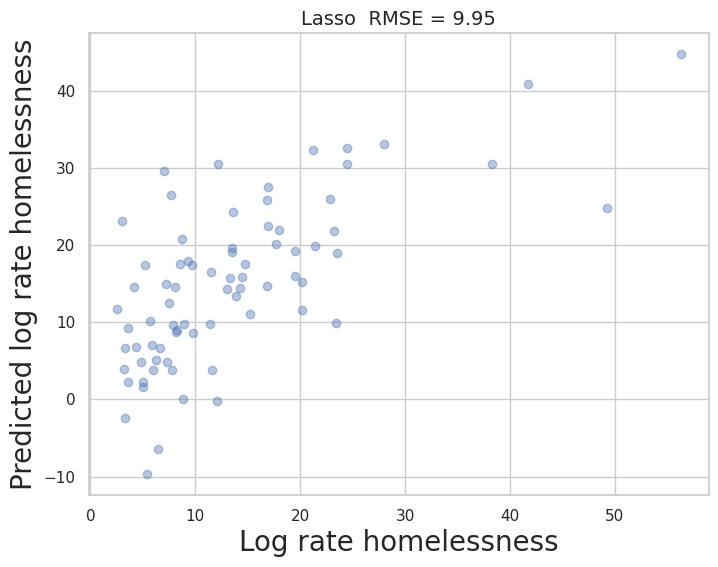

In [40]:
plt.figure(figsize=(8,6))

plt.plot(y_test, lasso_reg.predict(X_test),'o', alpha = 0.4)

plt.xlabel('Log rate homelessness',fontsize = 20)
plt.ylabel('Predicted log rate homelessness',fontsize = 20)
plt.title('Lasso' + ' ' + ' RMSE = ' + str(RMSE_lasso.round(2)),fontsize = 14);

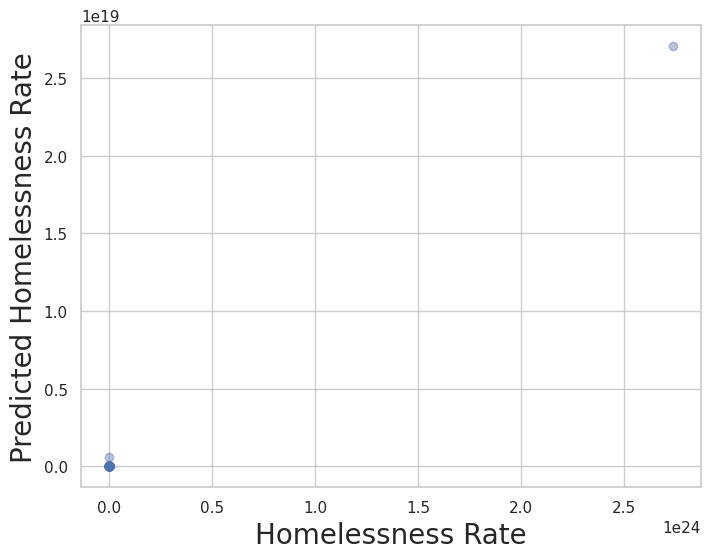

In [41]:
plt.figure(figsize=(8,6))

plt.plot(np.exp(y_test) - 1, np.exp(lasso_reg.predict(X_test))-1,'o', alpha = 0.4)

plt.xlabel('Homelessness Rate',fontsize = 20)
plt.ylabel('Predicted Homelessness Rate',fontsize = 20);

## Ridge Regression

In [42]:
alphas = 10**np.linspace(-3,7,20)

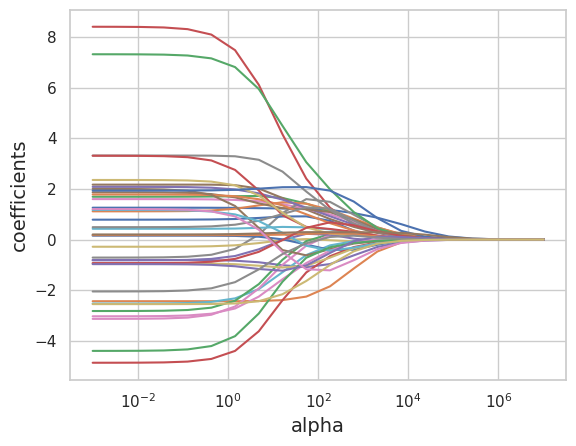

In [43]:
ridge = Ridge(max_iter = 100000)
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('coefficients', fontsize = 14);

In [44]:
ridgecv = RidgeCV(alphas = alphas, cv = 5, scoring = 'neg_mean_squared_error')

ridgecv.fit(X_train, y_train);

In [45]:
ridgecv.alpha_

183.29807108324337

In [46]:
ridge_reg = Ridge(alpha = ridgecv.alpha_).fit(X_train, y_train)

In [47]:
coefficients = ridge_reg.coef_.round(3)
coefficients = np.insert(coefficients, 0, ridge_reg.intercept_.round(3))

variables = X.columns
variables = np.insert(variables, 0, 'intercept')

pd.DataFrame(data = coefficients, index = variables, columns = ['Estimated Coefficient'])

,Estimated Coefficient
intercept,13.386
total_homeless,1.174
total_population,-1.849
house_price_index_2009,1.109
log_median_rent,1.259
utility_costs,-0.968
percentage_owners_cost_burden_2016,0.812
percentage_renters_severe_cost_burden_2016,0.996
share_renters_2016,1.491
rental_vacancy_rate,-0.026


In [48]:
MSE_ridge = mean_squared_error(y_test, ridge_reg.predict(X_test))
RMSE_ridge = np.sqrt(MSE_ridge)
R_squared_ridge = r2_score(y_test, ridge_reg.predict(X_test))

print('MSE =', MSE_ridge.round(3), ' RMSE =', RMSE_ridge.round(3), ' R-squared =', R_squared_ridge.round(3))

MSE = 62.614  RMSE = 7.913  R-squared = 0.398


In [49]:
MSE_ridge = mean_squared_error(y_train, ridge_reg.predict(X_train))
RMSE_ridge = np.sqrt(MSE_ridge)
R_squared_ridge = r2_score(y_train, ridge_reg.predict(X_train))

print('MSE =', MSE_ridge.round(3), ' RMSE =', RMSE_ridge.round(3), ' R-squared =', R_squared_ridge.round(3))

MSE = 110.945  RMSE = 10.533  R-squared = 0.593


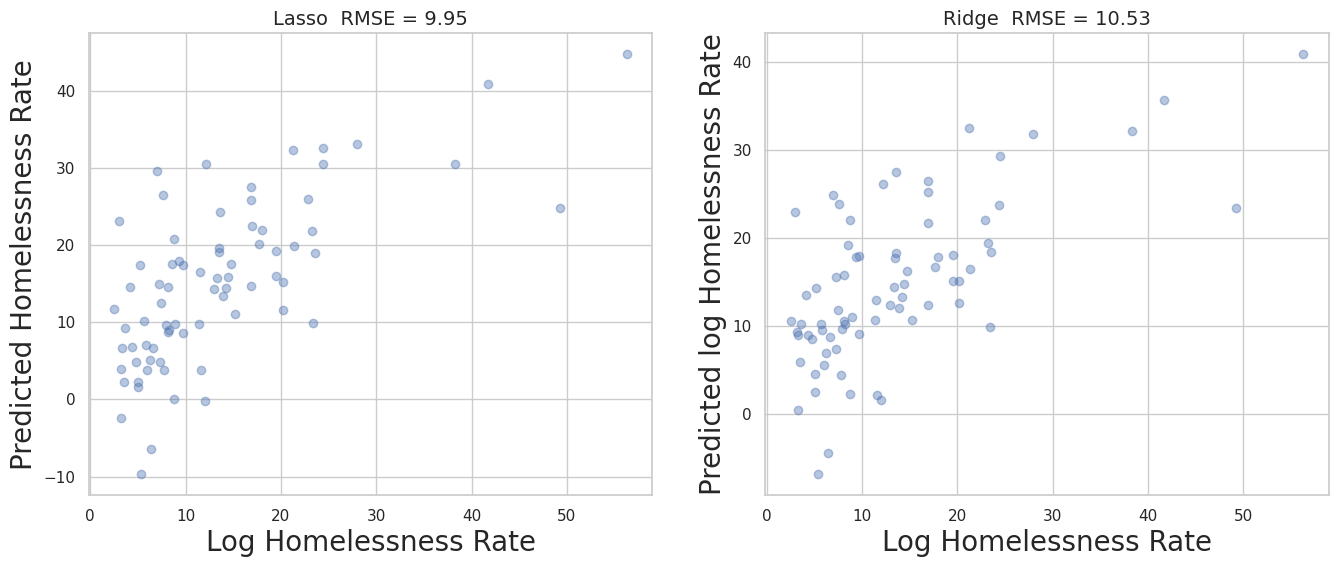

In [50]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(y_test, lasso_reg.predict(X_test),'o', alpha = 0.4)
plt.xlabel('Log Homelessness Rate',fontsize = 20)
plt.ylabel('Predicted Homelessness Rate',fontsize = 20)
plt.title('Lasso' + ' ' + ' RMSE = ' + str(RMSE_lasso.round(2)),fontsize = 14)

plt.subplot(1,2,2)
plt.plot(y_test, ridge_reg.predict(X_test),'o', alpha = 0.4)
plt.xlabel('Log Homelessness Rate',fontsize = 20)
plt.ylabel('Predicted log Homelessness Rate',fontsize = 20)
plt.title('Ridge' + ' ' + ' RMSE = ' + str(RMSE_ridge.round(2)),fontsize = 14);

plt.subplots_adjust(hspace = 0.5)

## XGBoost 

Now we'll use XGBoost to find predictions as it can efficiently process large data. 

In [51]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True, scoring = 'neg_mean_squared_error')

search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f2f55ddc850>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f2f50cb1d50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f2f50cdda20>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f2f50cdc6d0>},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [52]:
search.best_params_

{'colsample_bytree': 0.9141105592351576,
 'gamma': 0.30789724948173136,
 'learning_rate': 0.1803383614690916,
 'max_depth': 2,
 'n_estimators': 114,
 'subsample': 0.7367998203087146}

In [53]:
model_xgb = xgb.XGBRegressor(objective="reg:squarederror")

In [54]:
model_xgb.set_params(**search.best_params_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9141105592351576, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.30789724948173136, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1803383614690916, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=114, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Let's fit the model on the training data

In [55]:
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9141105592351576, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.30789724948173136, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1803383614690916, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=114, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [56]:
y_pred_xgb = model_xgb.predict(X_test)

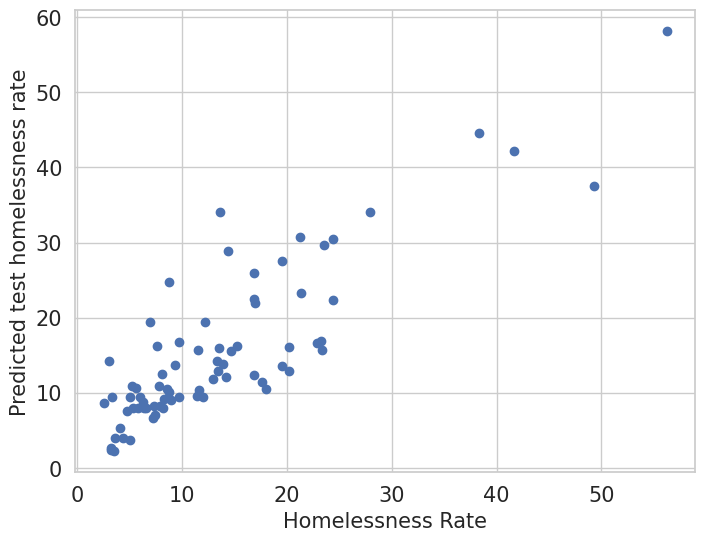

In [57]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_pred_xgb, 'o');

plt.xlabel('Homelessness Rate', fontsize = 15)
plt.ylabel('Predicted test homelessness rate', fontsize = 15)

plt.tick_params(labelsize = 15)

In [58]:
mean_squared_error(y_test, y_pred_xgb, squared = False).round(3)

5.876

In [59]:
mean_absolute_error(y_test, y_pred_xgb).round(3)

4.277

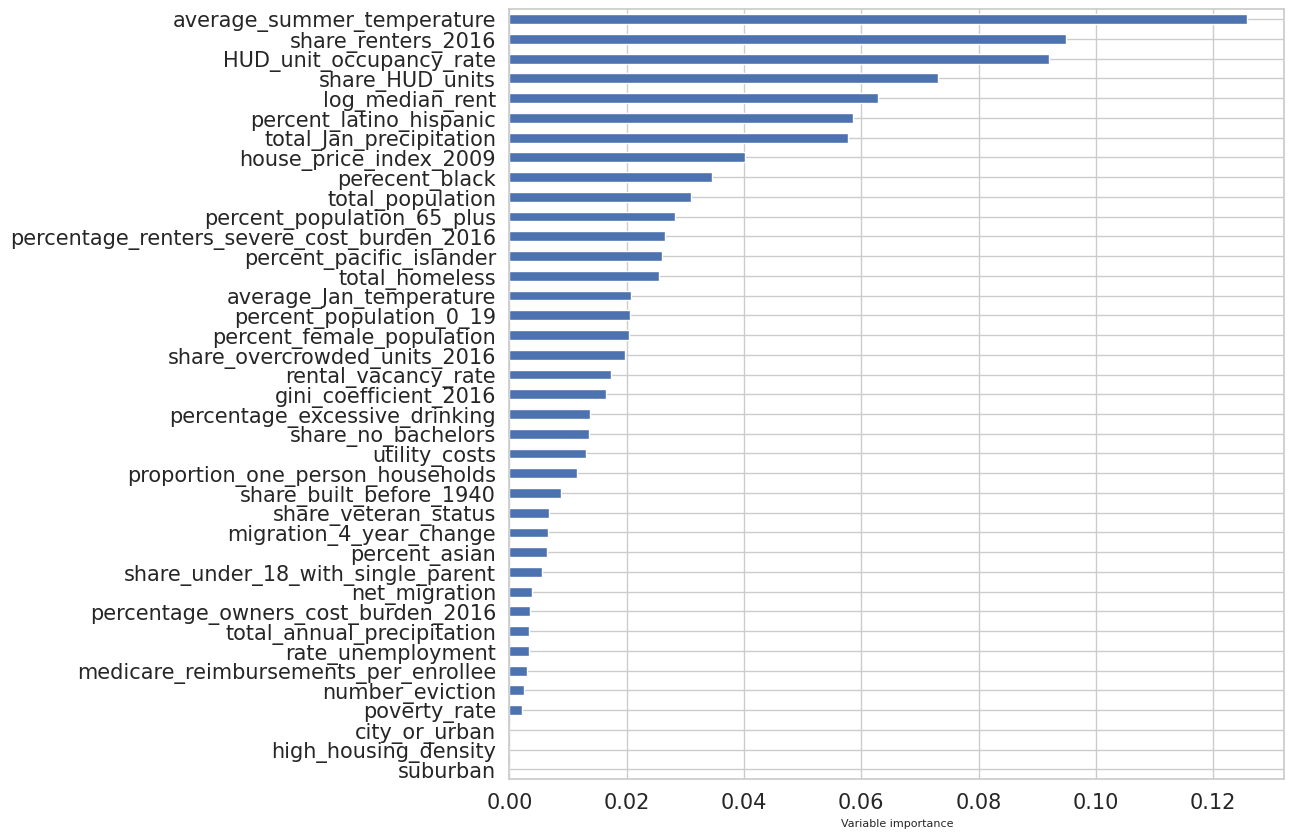

In [60]:
(pd.DataFrame(dict(cols=X.columns, imp=model_xgb.feature_importances_)).
 sort_values(by = 'imp').
 plot('cols', 'imp', 'barh', legend = False, figsize = (10,10)))

plt.ylabel('')
plt.xlabel('Variable importance', fontsize = 8)

plt.tick_params(labelsize = 15);

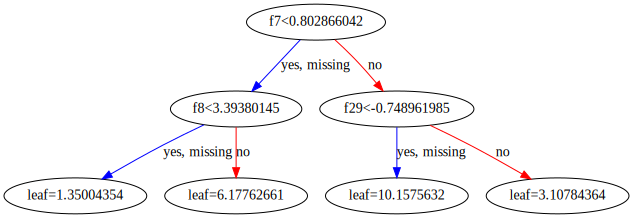

In [61]:
xgb.to_graphviz(model_xgb, num_trees=2) 

We can see the predictions that the xgboost tree models makes through the leaf nodes, indicating what the predictions for those given data points are.

## Additional Analysis

Let's look at the regression models if we fit it logarithmically.

In [80]:
X = df.drop(columns = ['coc_number', 'rate_homeless'])
y = np.log1p(df['rate_homeless'])

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 153)

In [82]:
print(X_train.shape, np.round(X_train.shape[0]/X_train.shape[1]))

(299, 39) 8.0


In [83]:
scaler = RobustScaler().fit(X_train)

In [84]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Fit the Model

In [85]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit() 

In [86]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          rate_homeless   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     12.54
Date:                Wed, 24 May 2023   Prob (F-statistic):           1.50e-40
Time:                        21:38:15   Log-Likelihood:                -146.25
No. Observations:                 299   AIC:                             372.5
Df Residuals:                     259   BIC:                             520.5
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6097      0.087     29.980      0.0

We can see this model has good significance as it has a large r-squared value of 0.654

In [69]:
variables = X.columns
variables = np.insert(variables, 0, 'intercept')

pd.DataFrame(index = variables, data = {'p-value':model.pvalues.values.round(3), 'significant': model.pvalues.values < 0.05})

,p-value,significant
intercept,0.000,True
total_homeless,0.000,True
total_population,0.000,True
house_price_index_2009,0.032,True
log_median_rent,0.003,True
utility_costs,0.505,False
percentage_owners_cost_burden_2016,0.113,False
percentage_renters_severe_cost_burden_2016,0.608,False
share_renters_2016,0.491,False
rental_vacancy_rate,0.252,False


Now let's use the model to predict the test data.

In [87]:
MSE = mean_squared_error(y_test, model.predict(sm.add_constant(X_test)))
RMSE = np.sqrt(MSE)
R_squared = r2_score(y_test, model.predict(sm.add_constant(X_test)))

print('MSE =', MSE.round(3), ' RMSE =', RMSE.round(3), ' R-squared =', R_squared.round(3))

MSE = 0.188  RMSE = 0.434  R-squared = 0.518


## Lasso

Now let's perform lasso and ridge regression again.

In [88]:
alphas = 10**np.linspace(-4,0,10)

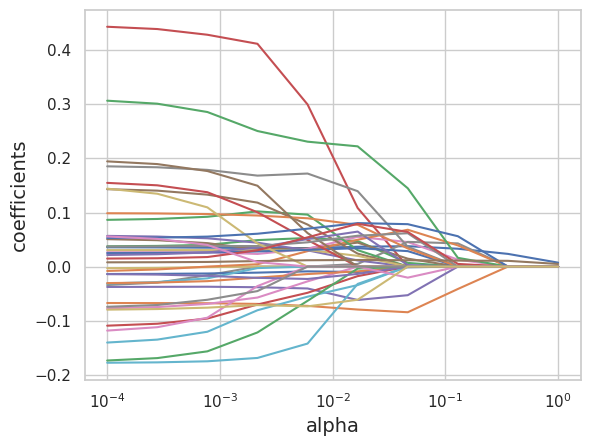

In [89]:
lasso = Lasso(max_iter = 100000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('coefficients', fontsize = 14);

In [90]:
lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100_000)

In [91]:
lassocv.fit(X_train, y_train)
lassocv.alpha_

0.3765028694762178

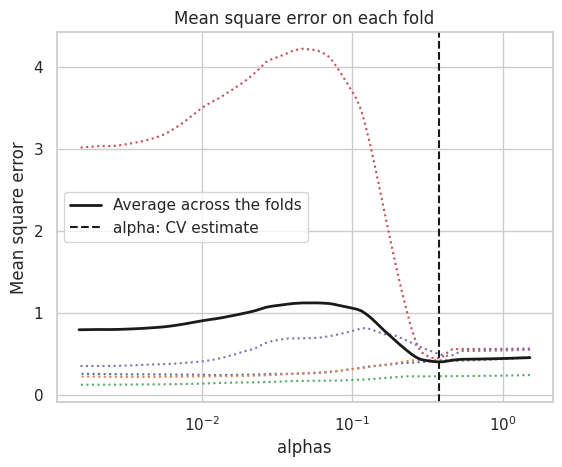

In [92]:
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, ":")
plt.plot(
    lassocv.alphas_ ,
    lassocv.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    lassocv.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight");

In [93]:
lasso_reg = Lasso(alpha = lassocv.alpha_).fit(X_train, y_train)

In [94]:
coefficients = lasso_reg.coef_.round(3)
coefficients = np.insert(coefficients, 0, lasso_reg.intercept_.round(4))

variables = X.columns
variables = np.insert(variables, 0, 'intercept')

pd.DataFrame(data = coefficients.round(2), index = variables, columns = ['Estimated Coefficient'])

,Estimated Coefficient
intercept,2.55
total_homeless,0.02
total_population,-0.00
house_price_index_2009,0.00
log_median_rent,0.00
utility_costs,-0.00
percentage_owners_cost_burden_2016,0.00
percentage_renters_severe_cost_burden_2016,0.00
share_renters_2016,0.00
rental_vacancy_rate,-0.00


Now we'll use the lasso model to predict the test data. 

In [95]:
MSE_lasso = mean_squared_error(y_test, lasso_reg.predict(X_test))
RMSE_lasso = np.sqrt(MSE_lasso)
R_squared_lasso = r2_score(y_test, lasso_reg.predict(X_test))

print('MSE =', MSE_lasso.round(3), ' RMSE =', RMSE_lasso.round(3), ' R-squared =', R_squared_lasso.round(3))

MSE = 0.36  RMSE = 0.6  R-squared = 0.081


Now let's make a scatter plot of the measure rate of homeleness vs. the predicted log rate of homelessness

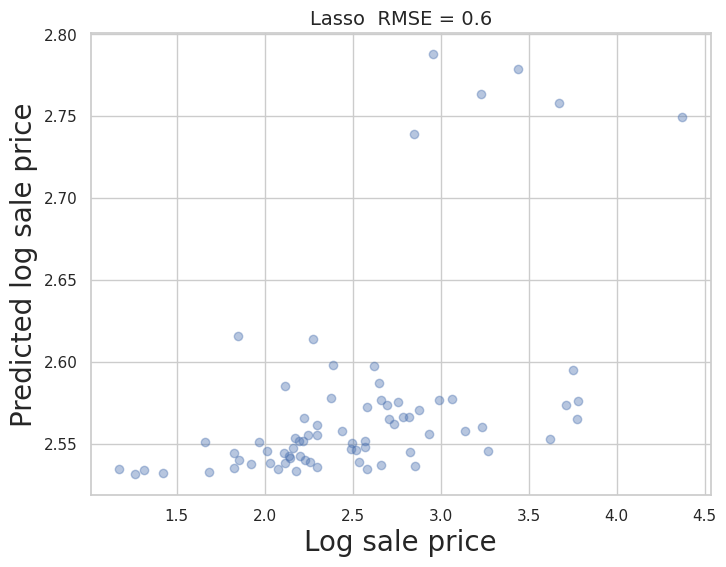

In [96]:
plt.figure(figsize=(8,6))

plt.plot(y_test, lasso_reg.predict(X_test),'o', alpha = 0.4)

plt.xlabel('Log sale price',fontsize = 20)
plt.ylabel('Predicted log sale price',fontsize = 20)
plt.title('Lasso' + ' ' + ' RMSE = ' + str(RMSE_lasso.round(2)),fontsize = 14);

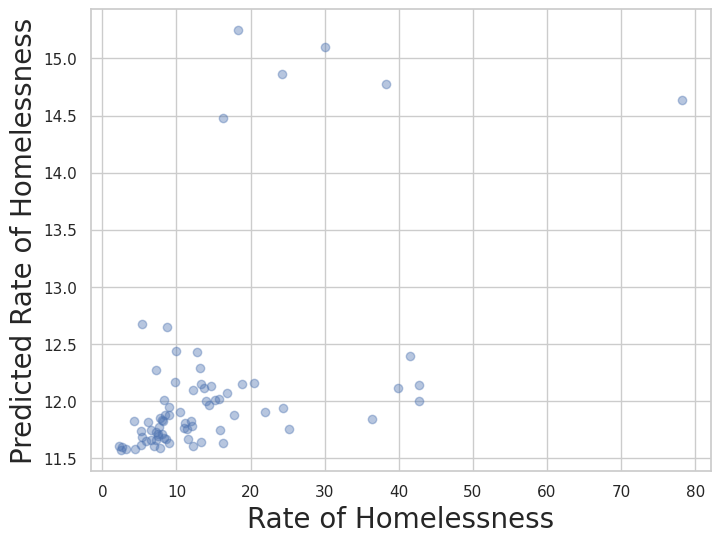

In [97]:
plt.figure(figsize=(8,6))

plt.plot(np.exp(y_test) - 1, np.exp(lasso_reg.predict(X_test))-1,'o', alpha = 0.4)

plt.xlabel('Rate of Homelessness',fontsize = 20)
plt.ylabel('Predicted Rate of Homelessness',fontsize = 20);

## Ridge Regression

Now let's use ridge regression to predict the model data.

In [98]:
alphas = 10**np.linspace(-3,5,20)

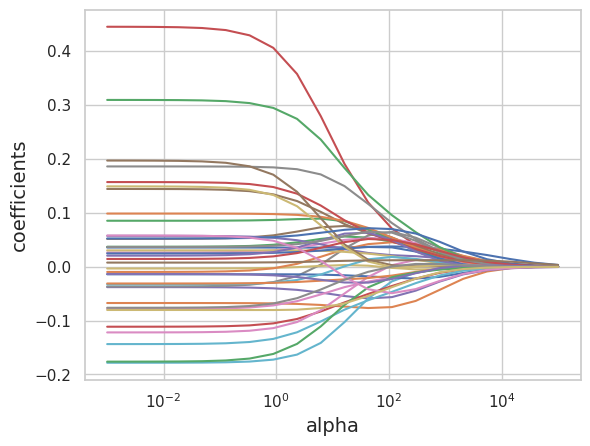

In [99]:
ridge = Ridge(max_iter = 100000)
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('coefficients', fontsize = 14);

In [100]:
ridgecv = RidgeCV(alphas = alphas, cv = 5, scoring = 'neg_mean_squared_error')

ridgecv.fit(X_train, y_train);

In [101]:
ridgecv.alpha_

2069.13808111479

In [102]:
ridge_reg = Ridge(alpha = ridgecv.alpha_).fit(X_train, y_train)

In [103]:
coefficients = ridge_reg.coef_.round(3)
coefficients = np.insert(coefficients, 0, ridge_reg.intercept_.round(3))

variables = X.columns
variables = np.insert(variables, 0, 'intercept')

pd.DataFrame(data = coefficients, index = variables, columns = ['Estimated Coefficient'])

,Estimated Coefficient
intercept,2.516
total_homeless,0.028
total_population,-0.022
house_price_index_2009,0.014
log_median_rent,0.011
utility_costs,-0.014
percentage_owners_cost_burden_2016,0.012
percentage_renters_severe_cost_burden_2016,0.018
share_renters_2016,0.020
rental_vacancy_rate,-0.003


In [104]:
MSE_ridge = mean_squared_error(y_test, ridge_reg.predict(X_test))
RMSE_ridge = np.sqrt(MSE_ridge)
R_squared_ridge = r2_score(y_test, ridge_reg.predict(X_test))

print('MSE =', MSE_ridge.round(3), ' RMSE =', RMSE_ridge.round(3), ' R-squared =', R_squared_ridge.round(3))

MSE = 0.276  RMSE = 0.525  R-squared = 0.295


Now we'll make a scatter plot of the measure rate of homelessness vs the predicted log rate of homelessness

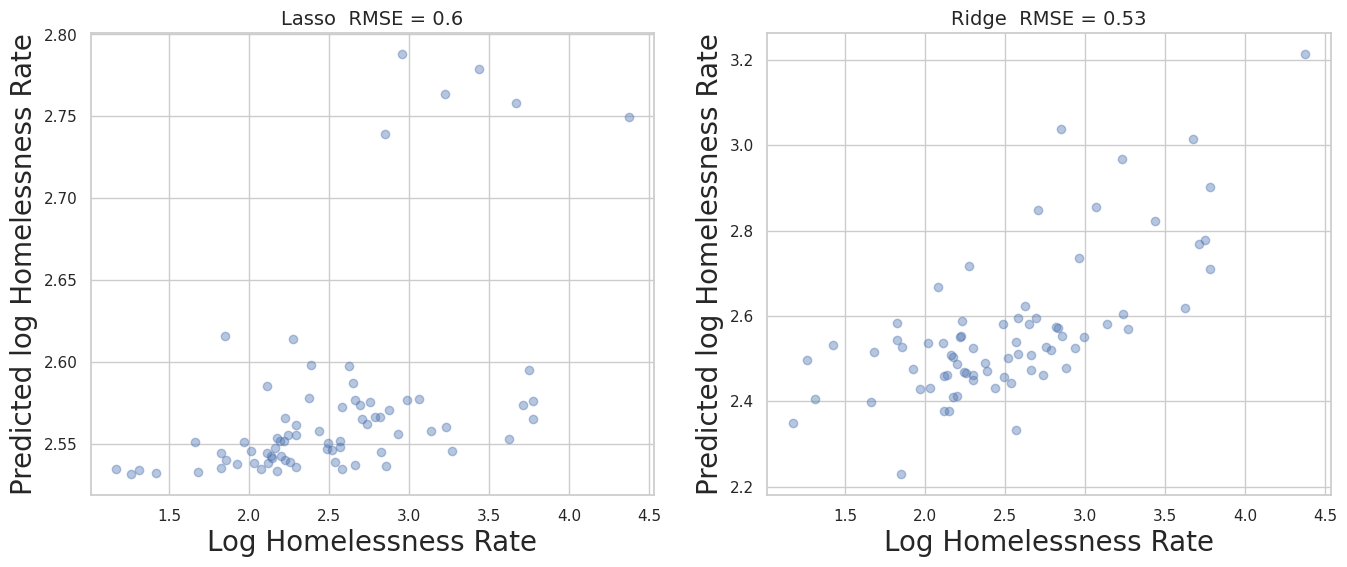

In [106]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(y_test, lasso_reg.predict(X_test),'o', alpha = 0.4)
plt.xlabel('Log Homelessness Rate',fontsize = 20)
plt.ylabel('Predicted log Homelessness Rate',fontsize = 20)
plt.title('Lasso' + ' ' + ' RMSE = ' + str(RMSE_lasso.round(2)),fontsize = 14)

plt.subplot(1,2,2)
plt.plot(y_test, ridge_reg.predict(X_test),'o', alpha = 0.4)
plt.xlabel('Log Homelessness Rate',fontsize = 20)
plt.ylabel('Predicted log Homelessness Rate',fontsize = 20)
plt.title('Ridge' + ' ' + ' RMSE = ' + str(RMSE_ridge.round(2)),fontsize = 14);

plt.subplots_adjust(hspace = 0.5)

## Conclusion

The overall problem is to determine whether and how housing market factors are related to homelessness. We can see that there is a correlation, and through our analysis we noticed that it was not a linear correlation. Through this we needed to fit nonlinear regression models to make more accurates estimates for our prediction of the homelessness rates. Furthermore, we performed regurlarization methods to ensure that we were not overfitting the data and trying to help with the skew the data set had. 

Through our regression models and our correlation matrix, we were able to ascertain the most relevant predictors to help with answering our problem. The most relevant predictors seeming to be, share_renters_2016, share_overcrowded_units_2016, house_price_index_2009, percentage_owners_cost_burden_2016, gini_coefficient_2016, log_median_rent, and utility_costs

We can see overall that we were able to predict homelessness rates in relation to housing market factors, however, our additional analysis showed a subtlely that it could potentially be a better fit with the model having a larger r-squared value compared to our models that were not logarithmic. 